# Loss vs Compute (OLMo PetaFLOPs)

This notebook plots training loss vs compute using OLMo's built-in petaflop tracking.

## Data Required

Export a CSV from WandB with these columns:
- `Step`
- `<run_name> - train/CE loss`
- `<run_name> - throughput/total petaflops`

To export: WandB → Project → Select runs → Export → CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================
CSV_PATH = 'wandb_export_with_petaflops.csv'
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

# Constants
# PF-day = 10^15 FLOPS * 86400 seconds = 8.64e19 FLOPs
# OLMo tracks cumulative petaflops (total FLOPs / 10^15)
# So: PF-days = petaflops / 86400
SECONDS_PER_DAY = 86400

print(f"Using data from: {CSV_PATH}")

Using data from: wandb_export_with_petaflops.csv


In [2]:
# Model display configurations
MODEL_CONFIGS = {
    'saturate_1M_15B_2': {
        'name': '1M Dense',
        'is_moe': False,
        'color': '#e7298a',
        'linestyle': '-',
    },
    'saturate_60M_15B': {
        'name': '60M Dense',
        'is_moe': False,
        'color': '#66a61e',
        'linestyle': '-',
    },
    'saturate_135M_15B_03': {
        'name': '135M Dense',
        'is_moe': False,
        'color': '#1f77b4',
        'linestyle': '-',
    },
    'saturate_271M_15B_2': {
        'name': '271M Dense',
        'is_moe': False,
        'color': '#ff7f0e',
        'linestyle': '-',
        'continuation': 'saturate_271M_15_2_cont',
    },
    'saturate_271M_15_2_cont': {
        'name': '271M Dense (cont)',
        'is_moe': False,
        'color': '#ff7f0e',
        'linestyle': '-',
        'is_continuation': True,
    },
    'saturate_1B_15B.py': {
        'name': '1B Dense',
        'is_moe': False,
        'color': '#2ca02c',
        'linestyle': '-',
    },
    'saturate_moe1Bsparse_15B': {
        'name': 'MoE-1B Sparse',
        'is_moe': True,
        'color': '#9467bd',
        'linestyle': '--',
    },
    'saturate_moe1Bolmo_15B': {
        'name': 'MoE-1B OLMo',
        'is_moe': True,
        'color': '#8c564b',
        'linestyle': '--',
    },
}

print("Model configurations loaded")

Model configurations loaded


In [3]:
# Load CSV
df = pd.read_csv(CSV_PATH)

print(f"Loaded {CSV_PATH}")
print(f"Shape: {df.shape}")

# Find all unique model names from columns
model_names = set()
for col in df.columns:
    if ' - train/CE loss' in col:
        model_names.add(col.replace(' - train/CE loss', ''))

print(f"\nFound {len(model_names)} models:")
for name in sorted(model_names):
    loss_col = f'{name} - train/CE loss'
    pflops_col = f'{name} - throughput/total petaflops'
    
    if loss_col in df.columns and pflops_col in df.columns:
        valid = df[loss_col].notna() & df[pflops_col].notna()
        n_points = valid.sum()
        if n_points > 0:
            losses = df.loc[valid, loss_col]
            pflops = df.loc[valid, pflops_col]
            print(f"  {name}: {n_points} pts, loss {losses.iloc[0]:.3f}->{losses.iloc[-1]:.3f}, pflops {pflops.iloc[0]:.1f}->{pflops.iloc[-1]:.1f}")

Loaded wandb_export_with_petaflops.csv
Shape: (5998, 24)

Found 8 models:
  saturate_135M_15B_03: 2998 pts, loss 10.928->3.436, pflops 2.0->3044.8
  saturate_1B_15B.py: 1693 pts, loss 10.890->3.392, pflops 14.8->12564.0
  saturate_1M_15B_2: 5998 pts, loss 10.828->5.742, pflops 0.0->42.3
  saturate_271M_15B_2: 510 pts, loss 10.903->4.139, pflops 4.1->1042.1
  saturate_271M_15_2_cont: 3182 pts, loss 4.132->3.226, pflops 1046.2->7533.3
  saturate_60M_15B: 2997 pts, loss 10.881->3.719, pflops 0.6->958.5
  saturate_moe1Bolmo_15B: 2997 pts, loss 10.898->3.180, pflops 4.7->6980.7
  saturate_moe1Bsparse_15B: 3022 pts, loss 10.930->3.426, pflops 1.4->2154.5


In [4]:
# Process runs - extract loss and petaflops
processed_runs = {}

# Find all unique model names
model_names = set()
for col in df.columns:
    if ' - train/CE loss' in col:
        model_names.add(col.replace(' - train/CE loss', ''))

for run_name in model_names:
    loss_col = f'{run_name} - train/CE loss'
    pflops_col = f'{run_name} - throughput/total petaflops'
    step_col = f'{run_name} - Step'
    
    if loss_col not in df.columns or pflops_col not in df.columns:
        print(f"Warning: Missing columns for {run_name}")
        continue
    
    # Get config (use defaults if not found)
    cfg = MODEL_CONFIGS.get(run_name, {
        'name': run_name,
        'is_moe': 'moe' in run_name.lower(),
        'color': '#333333',
        'linestyle': '-',
    })
    
    # Get data where both loss and petaflops are available
    mask = df[loss_col].notna() & df[pflops_col].notna()
    
    if mask.sum() == 0:
        print(f"Warning: No valid data points for {run_name}")
        continue
    
    # Use model-specific Step column if available, otherwise use row index
    if step_col in df.columns:
        steps = df.loc[mask, step_col].values.copy()
    else:
        steps = df.loc[mask].index.values.copy()
    
    losses = df.loc[mask, loss_col].values.copy()
    petaflops = df.loc[mask, pflops_col].values.copy()
    
    # Sort by petaflops to ensure correct ordering
    sort_idx = np.argsort(petaflops)
    steps = steps[sort_idx]
    losses = losses[sort_idx]
    petaflops = petaflops[sort_idx]
    
    # Convert petaflops to PF-days
    pf_days = petaflops / SECONDS_PER_DAY
    
    processed_runs[run_name] = {
        'steps': steps,
        'losses': losses,
        'petaflops': petaflops,
        'pf_days': pf_days,
        'config': cfg,
    }
    
    print(f"{cfg['name']:<20}: {len(steps):>4} pts, loss {losses[0]:.3f}->{losses[-1]:.3f}, {pf_days[-1]:.4f} PF-days")

# Helper function
def get_run_data(run_name, include_continuation=True):
    """Get run data with continuation merged if available."""
    if run_name not in processed_runs:
        return None
    
    data = processed_runs[run_name]
    cfg = data['config']
    
    pf_days = data['pf_days'].copy()
    losses = data['losses'].copy()
    steps = data['steps'].copy()
    petaflops = data['petaflops'].copy()
    
    # Handle continuation runs (petaflops in continuation is already cumulative from wandb)
    if include_continuation and 'continuation' in cfg and cfg['continuation'] in processed_runs:
        cont = processed_runs[cfg['continuation']]
        # Continuation data is already cumulative, just concatenate
        pf_days = np.concatenate([pf_days, cont['pf_days'].copy()])
        losses = np.concatenate([losses, cont['losses'].copy()])
        steps = np.concatenate([steps, cont['steps'].copy()])
        petaflops = np.concatenate([petaflops, cont['petaflops'].copy()])
        
        # Re-sort by petaflops after concatenation
        sort_idx = np.argsort(pf_days)
        pf_days = pf_days[sort_idx]
        losses = losses[sort_idx]
        steps = steps[sort_idx]
        petaflops = petaflops[sort_idx]
    
    return {'pf_days': pf_days, 'losses': losses, 'steps': steps, 'petaflops': petaflops, 'config': cfg}

print(f"\nProcessed {len(processed_runs)} runs")

MoE-1B Sparse       : 3022 pts, loss 10.930->3.426, 0.0249 PF-days
MoE-1B OLMo         : 2997 pts, loss 10.898->3.180, 0.0808 PF-days
1B Dense            : 1693 pts, loss 10.890->3.392, 0.1454 PF-days
1M Dense            : 5998 pts, loss 10.828->5.742, 0.0005 PF-days
60M Dense           : 2997 pts, loss 10.881->3.719, 0.0111 PF-days
271M Dense (cont)   : 3182 pts, loss 4.132->3.226, 0.0872 PF-days
135M Dense          : 2998 pts, loss 10.928->3.436, 0.0352 PF-days
271M Dense          :  510 pts, loss 10.903->4.139, 0.0121 PF-days

Processed 8 runs


## OpenAI Scaling Law

From Kaplan et al. (2020):
$$L = \left(\frac{C}{2.3 \times 10^8}\right)^{-0.050}$$

In [5]:
def openai_scaling_law(pf_days):
    """OpenAI's compute-optimal scaling law."""
    return (pf_days / 2.3e8) ** (-0.050)

print("OpenAI Scaling Law: L = (C / 2.3e8)^(-0.050)")
print("\nPredictions:")
for pf in [1e-5, 1e-3, 1e-1, 1e0, 1e1]:
    print(f"  C = {pf:.0e} PF-days -> Loss = {openai_scaling_law(pf):.3f}")

OpenAI Scaling Law: L = (C / 2.3e8)^(-0.050)

Predictions:
  C = 1e-05 PF-days -> Loss = 4.657
  C = 1e-03 PF-days -> Loss = 3.699
  C = 1e-01 PF-days -> Loss = 2.938
  C = 1e+00 PF-days -> Loss = 2.619
  C = 1e+01 PF-days -> Loss = 2.334


## Loss vs Compute (PF-days) - Using OLMo's Petaflop Tracking

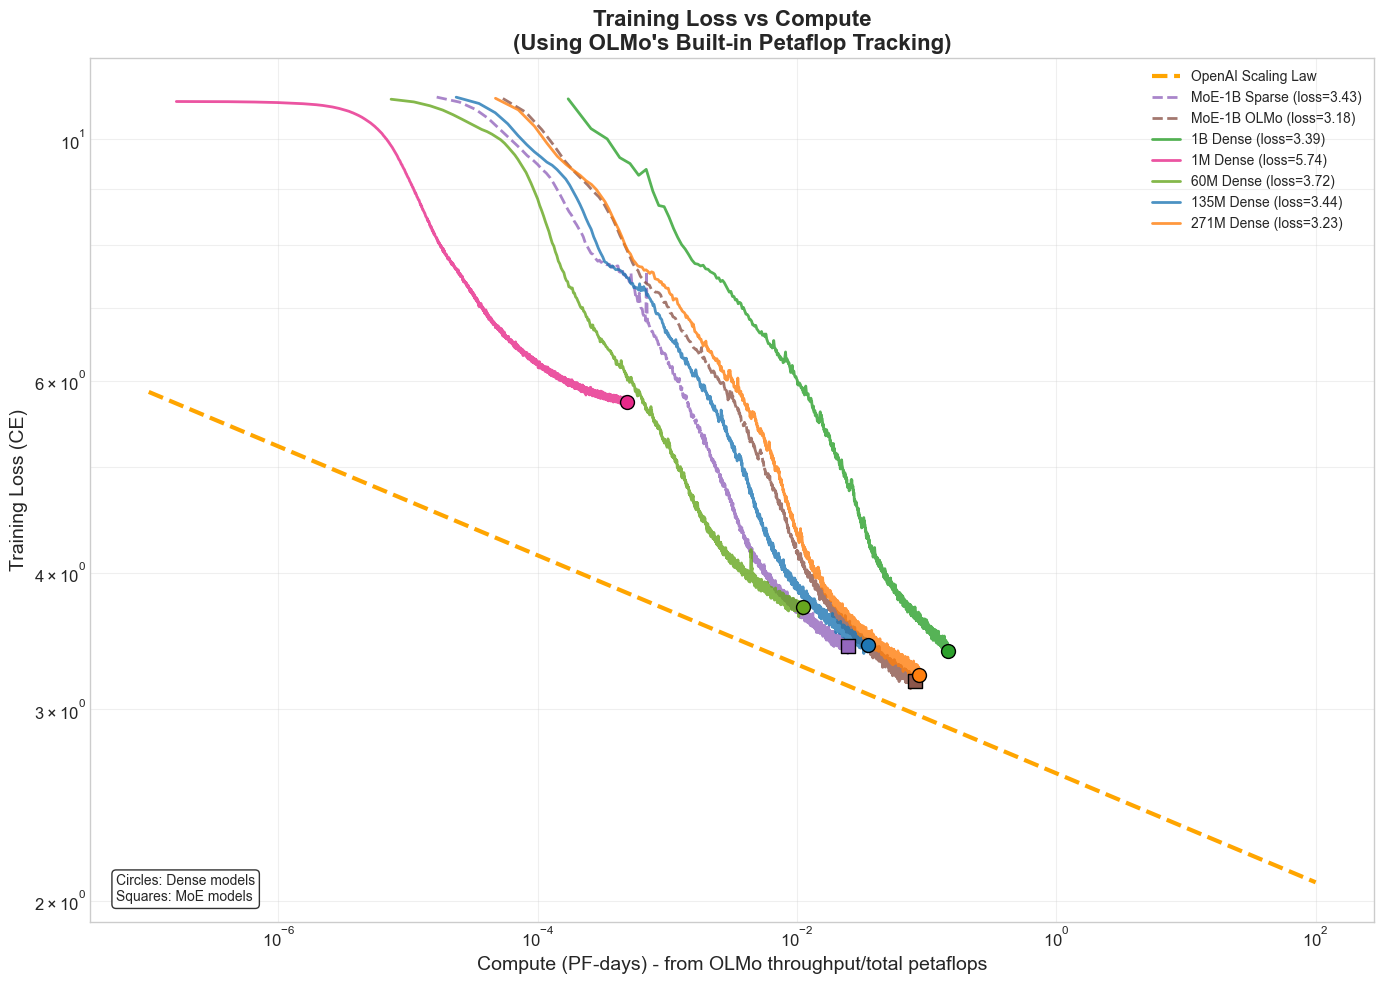


Note: PF-days = total_petaflops / 86400
OLMo's petaflops = cumulative FLOPs / 10^15


In [6]:
fig, ax = plt.subplots(figsize=(14, 10))

# Plot OpenAI scaling law
compute_range = np.logspace(-7, 2, 1000)
ax.plot(compute_range, openai_scaling_law(compute_range), '--', color='orange', 
        linewidth=3, label=r'OpenAI Scaling Law', zorder=10)

# Plot each run
for run_name in processed_runs.keys():
    data = get_run_data(run_name, include_continuation=True)
    if data is None:
        continue
    
    cfg = data['config']
    if cfg.get('is_continuation'):
        continue
    
    pf_days = data['pf_days']
    losses = data['losses']
    
    # Filter positive values for log scale
    valid = pf_days > 0
    if not np.any(valid):
        print(f"Warning: {cfg['name']} has no valid pf_days")
        continue
    
    pf_days = pf_days[valid]
    losses = losses[valid]
    
    # Plot line
    label = f"{cfg['name']} (loss={losses[-1]:.2f})"
    ax.plot(pf_days, losses, 
            color=cfg['color'], 
            linestyle=cfg['linestyle'],
            linewidth=2, alpha=0.8,
            label=label)
    
    # Mark endpoint
    marker = 's' if cfg['is_moe'] else 'o'
    ax.scatter([pf_days[-1]], [losses[-1]], 
               color=cfg['color'], s=100, marker=marker,
               edgecolors='black', linewidth=1, zorder=5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PF-days) - from OLMo throughput/total petaflops', fontsize=14)
ax.set_ylabel('Training Loss (CE)', fontsize=14)
ax.set_title('Training Loss vs Compute\n(Using OLMo\'s Built-in Petaflop Tracking)', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# Annotation
ax.text(0.02, 0.02, 'Circles: Dense models\nSquares: MoE models', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('loss_vs_compute_olmo_pflops.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: PF-days = total_petaflops / 86400")
print("OLMo's petaflops = cumulative FLOPs / 10^15")

## Summary Table

In [7]:
print("="*90)
print("SUMMARY: Final Loss and Compute")
print("="*90)
print(f"{'Model':<20} {'Type':<8} {'Final Loss':<12} {'PetaFLOPs':<15} {'PF-days':<12}")
print("-"*90)

results = []
for run_name in processed_runs.keys():
    data = get_run_data(run_name, include_continuation=True)
    if data is None:
        continue
    cfg = data['config']
    if cfg.get('is_continuation'):
        continue
    
    pf_days = data['pf_days']
    losses = data['losses']
    petaflops = data['petaflops']
    
    valid = pf_days > 0
    if np.any(valid):
        final_loss = losses[valid][-1]
        final_pf_days = pf_days[valid][-1]
        final_petaflops = petaflops[valid][-1]
        
        mtype = 'MoE' if cfg['is_moe'] else 'Dense'
        print(f"{cfg['name']:<20} {mtype:<8} {final_loss:<12.3f} {final_petaflops:<15.2f} {final_pf_days:<12.4f}")
        
        results.append({
            'name': cfg['name'],
            'type': mtype,
            'final_loss': final_loss,
            'petaflops': final_petaflops,
            'pf_days': final_pf_days,
        })

print("\n" + "="*90)
print("Sorted by final loss:")
print("="*90)
for r in sorted(results, key=lambda x: x['final_loss']):
    print(f"{r['name']:<20} {r['type']:<8} loss={r['final_loss']:.3f}  compute={r['pf_days']:.4f} PF-days")

SUMMARY: Final Loss and Compute
Model                Type     Final Loss   PetaFLOPs       PF-days     
------------------------------------------------------------------------------------------
MoE-1B Sparse        MoE      3.426        2154.51         0.0249      
MoE-1B OLMo          MoE      3.180        6980.66         0.0808      
1B Dense             Dense    3.392        12564.01        0.1454      
1M Dense             Dense    5.742        42.29           0.0005      
60M Dense            Dense    3.719        958.45          0.0111      
135M Dense           Dense    3.436        3044.77         0.0352      
271M Dense           Dense    3.226        7533.27         0.0872      

Sorted by final loss:
MoE-1B OLMo          MoE      loss=3.180  compute=0.0808 PF-days
271M Dense           Dense    loss=3.226  compute=0.0872 PF-days
1B Dense             Dense    loss=3.392  compute=0.1454 PF-days
MoE-1B Sparse        MoE      loss=3.426  compute=0.0249 PF-days
135M Dense        

## Comparison: OLMo vs Manual PF-days Calculation

OLMo's calculation:
- Uses `num_flops_per_token(seq_len)` from the model
- Accounts for actual sequence lengths
- Tracks cumulative FLOPs during training

Manual calculation (from previous notebook):
- Uses formula: $C = 6 \times N_{active} \times D$
- $N_{active}$ = non-embedding params (or active params for MoE)
- $D$ = tokens processed

In [8]:
print("\nKey differences between OLMo's tracking and manual calculation:")
print("""\n
1. OLMo's `num_flops_per_token` accounts for:
   - Attention FLOPs (including sequence length effects)
   - MLP FLOPs
   - Embedding lookups
   - Layer norms
   
2. Manual C = 6ND assumes:
   - 2N FLOPs for forward pass
   - 4N FLOPs for backward pass
   - Ignores attention's O(seq_len²) component
   
3. For MoE models:
   - OLMo tracks actual expert activations
   - Manual uses estimated "active params"

OLMo's tracking is more accurate for comparing across architectures.
""")


Key differences between OLMo's tracking and manual calculation:


1. OLMo's `num_flops_per_token` accounts for:
   - Attention FLOPs (including sequence length effects)
   - MLP FLOPs
   - Embedding lookups
   - Layer norms

2. Manual C = 6ND assumes:
   - 2N FLOPs for forward pass
   - 4N FLOPs for backward pass
   - Ignores attention's O(seq_len²) component

3. For MoE models:
   - OLMo tracks actual expert activations
   - Manual uses estimated "active params"

OLMo's tracking is more accurate for comparing across architectures.

